In [141]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import IntegerLookup
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [142]:
#Load data into ratings_df. 
ratings_df = pd.read_csv("data/ratings_small.csv", low_memory=False)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [143]:
unique_movie_ids = np.unique(ratings_df['movieId'])
unique_user_ids = np.unique(ratings_df['userId'])
num_movies = len(unique_movie_ids)
num_users = len(unique_user_ids)
user2user_encoded = {x: i for i, x in enumerate(unique_user_ids)}
userencoded2user = {i: x for i, x in enumerate(unique_user_ids)}
movie_ids = ratings_df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(unique_movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(unique_movie_ids)}
ratings_df["user"] = ratings_df["userId"].map(user2user_encoded)
ratings_df["movie"] = ratings_df["movieId"].map(movie2movie_encoded)

In [144]:
ratings_df["chron_ranking_by_user"] = ratings_df.groupby(["userId"])["timestamp"] \
                                             .rank(method='first', ascending=False)

train_ratings_df = ratings_df[ratings_df["chron_ranking_by_user"] > 2]
dev_ratings_df = ratings_df[ratings_df["chron_ranking_by_user"] == 2]
test_ratings_df = ratings_df[ratings_df["chron_ranking_by_user"] == 1]

In [145]:
train_ratings_df

,userId,movieId,rating,timestamp,user,movie,chron_ranking_by_user
0,1,31,2.5,1260759144,0,30,13.0
1,1,1029,3.0,1260759179,0,833,10.0
2,1,1061,3.0,1260759182,0,859,9.0
3,1,1129,2.0,1260759185,0,906,8.0
5,1,1263,2.0,1260759151,0,1017,11.0
...,...,...,...,...,...,...,...
99998,671,6212,2.5,1065149436,670,4507,13.0
99999,671,6268,2.5,1065579370,670,4545,8.0
100000,671,6269,4.0,1065149201,670,4546,19.0
100001,671,6365,4.0,1070940363,670,4597,4.0


In [146]:
embedding_size = 50
d1_size = 128

#Movie input network
input_movies = layers.Input(shape=[1])
#encoded_movies = IntegerLookup(vocabulary=unique_movie_ids)
embed_movies = layers.Embedding(num_movies + 1, embedding_size)(input_movies)
movies_out = layers.Flatten()(embed_movies)

#user input network
input_users = layers.Input(shape=[1])
#encoded_users = IntegerLookup(vocabulary=unique_user_ids)
embed_users = layers.Embedding(num_users + 1,embedding_size)(input_users)
users_out = keras.layers.Flatten()(embed_users)

conc_layer = keras.layers.Concatenate()([movies_out, users_out])
x = keras.layers.Dense(d1_size, activation='relu')(conc_layer)
x_out = x = keras.layers.Dense(1, activation='relu')(x)
model = keras.Model(inputs=[input_movies, input_users], outputs=x_out)

In [147]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_47 (Embedding)        (None, 1, 50)        453350      input_17[0][0]                   
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 1, 50)        33600       input_18[0][0]                   
____________________________________________________________________________________________

In [148]:
hist = model.fit(
    x=[train_ratings_df.movie, train_ratings_df.user],
    y=train_ratings_df.rating, 
    batch_size=64, 
    epochs=5, 
    verbose=1,
    validation_data=([dev_ratings_df.movie, dev_ratings_df.user], dev_ratings_df.rating)
)

Epoch 1/5
1542/1542 [==============================] - 6s 4ms/step - loss: 1.2787 - val_loss: 0.9435
Epoch 2/5
1542/1542 [==============================] - 7s 4ms/step - loss: 0.7510 - val_loss: 0.8975
Epoch 3/5
1542/1542 [==============================] - 7s 5ms/step - loss: 0.7094 - val_loss: 0.8768
Epoch 4/5
1542/1542 [==============================] - 7s 5ms/step - loss: 0.6806 - val_loss: 0.8685
Epoch 5/5
1542/1542 [==============================] - 9s 6ms/step - loss: 0.6485 - val_loss: 0.8800


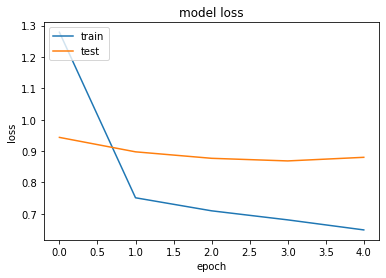

In [150]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Ignore Work After this point

In [153]:
Embedding_size = 50
d1_size = 128

#Movie input network
input_movies = layers.Input(shape=[1])
#encoded_movies = IntegerLookup(vocabulary=unique_movie_ids)
embed_movies = layers.Embedding(num_movies, 
                                embedding_size, 
                                embeddings_initializer="he_normal",
                                embeddings_regularizer=keras.regularizers.l2(1e-6))(input_movies)
movies_bias = layers.Embedding(num_movies, 1)



#user input network
input_users = layers.Input(shape=[1])
#encoded_users = IntegerLookup(vocabulary=unique_user_ids)
embed_users = layers.Embedding(num_users,
                               embedding_size,
                               embeddings_initializer="he_normal",
                               embeddings_regularizer=keras.regularizers.l2(1e-6))(input_users)
users_bias = layers.Embedding(num_users, 1)

users_vector = embed_users(inputs[:, 0])
users_bias = users_bias(inputs[:, 0])
movies_vector = embed_movies(inputs[:, 1])
movies_bias = movies_bias(inputs[:, 1])
dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
x = dot_user_movie + user_bias + movie_bias
x_out = tf.nn.sigmoid(x)

model = keras.Model(inputs=[input_movies, input_users], outputs=x_out)

NameError: name 'inputs' is not defined

In [152]:
hist_2 = model_2.fit(
    x=[train_ratings_df.movie, train_ratings_df.user],
    y=train_ratings_df.rating, 
    batch_size=64, 
    epochs=5, 
    verbose=1,
    validation_data=([dev_ratings_df.movie, dev_ratings_df.user], dev_ratings_df.rating)
)

Epoch 1/5


TypeError: in user code:

    /Users/rathin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    <ipython-input-68-5a5196417180>:26 call  *
        user_vector = self.user_embedding(inputs[:, 0])

    TypeError: tuple indices must be integers or slices, not tuple


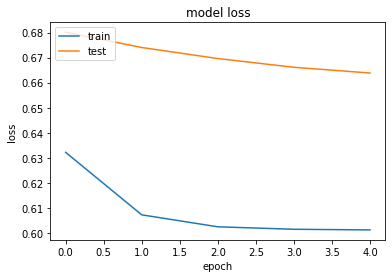

In [70]:
plt.plot(hist_2.history["loss"])
plt.plot(hist_2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model_2 = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model_2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)